In [146]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

import embedding as emb
reload(emb)
from embedding import *

### retrieve experimental sketch data and metadata

In [138]:
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[1]

# extract metadata
path_to_sketches = 'subject_data'
sketch_paths = sorted(list_files(path_to_sketches))
labels = map(get_label_from_path,sketch_paths)
trialNum = map(get_trial_from_path,sketch_paths)
subj = map(get_subj_from_path,sketch_paths)

# augment with additional metadata from each subject's metadata file
sub_dirs = [i for i in sorted(os.listdir(path_to_sketches)) if i[-11:]=='neurosketch']
path_to_sub_meta = [os.path.join(path_to_sketches,s,s+'_metadata.csv') for s in sub_dirs]

# concatenate all subjects' metadata files
Y = []
for p in path_to_sub_meta:
    _Y = pd.read_csv(p)
    if len(Y)==0:
        Y = _Y
    else:
        Y = pd.concat([Y,_Y],ignore_index=True)
        
# validate that the order is the same in the supersubject metadata file (Y) and the lists generated from sketch_paths        
subs = list(Y.wID.values)
merged = zip(subj,subs)
assert len([(i,j) for (i,j) in merged if i != j])==0        

competitors = list(Y.competitor.values)
version = list(Y.version.values)
viewpoint = list(Y.viewpoint.values)

objpose = [i+str(j) for (i,j) in zip(list(labels),list(viewpoint))]

# organize into dataframe
X = pd.DataFrame([subj,trialNum,labels,competitors,version,viewpoint,sketch_paths,objpose])
X = X.transpose()
X.columns = ['subj','trial','label','competitor','version','viewpoint','path','objpose']

print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of subjects: ' + str(len(np.unique(subj)))

num_sketches = len(sketch_paths)

############### assign axis to metadata file ##################
unique_axes = ['bed_bench','bed_chair','bed_table','bench_chair','bench_table','chair_table']

def assign_axis_to_metadata(_X):
    _combos = [i+'_'+j for (i,j) in zip(list(_X.label.values),list(_X.competitor.values))]
    lookup = {'bed_bench':'bed_bench',
              'bench_bed':'bed_bench',
              'bed_chair':'bed_chair',
              'chair_bed':'bed_chair',
              'bed_table':'bed_table',
              'table_bed':'bed_table',
              'bench_chair':'bench_chair',
              'chair_bench':'bench_chair',
              'bench_table':'bench_table',
              'table_bench':'bench_table',
              'chair_table':'chair_table',
              'table_chair':'chair_table',          
             }
    axis = [lookup[c] for c in _combos]
    _X = _X.assign(axis=pd.Series(axis).values)
    return _X

X = assign_axis_to_metadata(X)
X.to_csv('METADATA_RAW.csv')

############ BASELINE sketch paths ##############
path_to_baselines = '../baseline_sketches'
baseline_paths = sorted(list_files(path_to_baselines))
def get_label_from_baseline_path(path):
    return path.split('/')[-1].split('_')[0]
def get_view_from_baseline_path(path):
    return path.split('/')[-1].split('_')[1]
def get_instance_from_baseline_path(path):
    return path.split('/')[-1].split('_')[2]

baseline_labels = map(get_label_from_baseline_path,baseline_paths)
baseline_views = map(get_view_from_baseline_path,baseline_paths)
baseline_instances = map(get_instance_from_baseline_path,baseline_paths)
B = pd.read_csv(os.path.join(path_to_baselines,'baseline_sketches_metadata.csv'))

Number of sketches: 1400
Number of subjects: 35


### extract vgg19 features from main dataset

In [43]:
extractor = FeatureExtractor(sketch_paths,6)
Features, Labels = extractor.extract_feature_matrix()

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
stopped!


In [44]:
extract_baseline = 0
if extract_baseline:
    BaselineFeatureExtractor = FeatureExtractor(baseline_paths,6)
    BaselineFeatures, BaselineLabels = BaselineFeatureExtractor.extract_feature_matrix()

### preprocess features, save out, basic visualizations

In [143]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def preprocess_features(Features, Labels, X):
    # normalize feature vectors & plot full image-level similarity matrix
    _X = X.sort_values(['label','viewpoint','subj'])
    inds = np.array(_X.index)
    _Features = normalize(Features[inds])
    _Labels = Labels[inds]
    return _Features, _Labels, _X

def save_features(Features, Labels, X, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']
    np.save('FEATURES_{}.npy'.format(layers[layer_num]), Features)
    np.save('LABELS.npy', Labels)
    X.to_csv('METADATA.csv')
    return layer_num

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_views(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    views = _X.objpose.values
    means = get_class_means(Features, views)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    plt.close()        

### Extracting, preprocessing, and saving out all layers

In [142]:
X = pd.read_csv('METADATA_RAW.csv')
for layer_ind in np.arange(6,7):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    print('Extracting Layer {}'.format(layers[layer_ind]))
    extractor = FeatureExtractor(sketch_paths,layer_ind)
    Features, Labels = extractor.extract_feature_matrix()    
    print('Preprocessing features...')
    subset_size = 25000 ## if num feature dimensions exceeds this value, take random subset of features
    if Features.shape[1]>25000:
        subset_inds = np.random.RandomState(0).permutation(Features.shape[1])[:subset_size]
        Features = Features[:,subset_inds]        
    _Features, _Labels, _X = preprocess_features(Features, Labels, X)
    _X = assign_axis_to_metadata(_X)
    layer_num = save_features(_Features, _Labels, _X, layer_ind)
    plot_rdm_by_views(_Features, _X, layer_ind)

Extracting Layer FC7
Batch 5
Batch 10
Batch 15
Batch 20
stopped!
Preprocessing features...


### Load in features 


In [144]:
layers = ['P1','P2','P3','P4','P5','FC6','FC7']
layer_names = ['pool1','pool2','pool3','pool4','pool5','fc6','fc7']
which_feat = 'pool1'
_X = pd.read_csv('METADATA.csv') # metadata is the same for all layers
_Labels = np.load('LABELS.npy')
_Features = np.load('FEATURES_{}.npy'.format(layers[layer_names.index(which_feat)]))

### Softmax classifier test

In [121]:
FEAT = _Features
LABELS = _Labels
# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)
run_this = 0
if run_this:
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [122]:
# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.2, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

0.65


## Analyze time course during training 

#### moving window across whole training phase

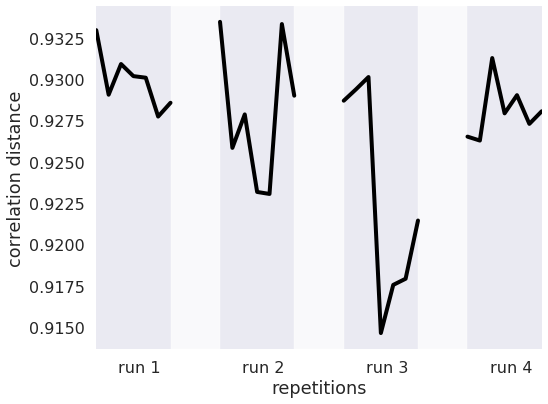

In [145]:
### which feature embedding are you using?
which_feat = 'pool1'
FEATMAT = np.load('FEATURES_{}.npy'.format(layers[layer_names.index(which_feat)]))
_X = pd.read_csv('METADATA.csv') # metadata is the same for all layers
_Labels = np.load('LABELS.npy')

# width of moving window in # of trials    
window_size = 4 
first_trial = int(min(X.trial))
last_trial = int(max(X.trial))
num_windows = last_trial-first_trial-window_size+2 ##     

import scipy.stats as stats
SIM = []
subs = np.unique(_X.subj)
for sub in subs:
    sim = []
    for n in np.arange(num_windows):
        start = first_trial + n
        end = first_trial + n + window_size
        span = np.arange(start,end)
        axis = np.unique(_X[_X.subj==sub].axis.values)[0]
        o1 = axis.split('_')[0]
        o2 = axis.split('_')[1]
        o1_inds = (_X.label==o1) & (_X.subj==sub) & (pd.to_numeric(_X['trial'])>=start) & (pd.to_numeric(_X['trial'])<end)
        o2_inds = (_X.label==o2) & (_X.subj==sub) & (pd.to_numeric(_X['trial'])>=start) & (pd.to_numeric(_X['trial'])<end)
        assert sum(o1_inds)==window_size/2
        assert sum(o2_inds)==window_size/2        
        FEAT_o1 = FEATMAT[o1_inds]
        FEAT_o2 = FEATMAT[o2_inds]
        MEANFEAT_o1 = FEATMAT[o1_inds].mean(0)
        MEANFEAT_o2 = FEATMAT[o2_inds].mean(0)
        sim.append(stats.pearsonr(MEANFEAT_o1,MEANFEAT_o2)[0])
    SIM.append(sim)
SIM = np.array(SIM)

## plot time series across runs of training
sns.set_context('poster')
sns.set_style('dark')
fig = plt.figure(figsize=(8,6))
plt.xlabel('repetitions')
plt.ylabel('correlation distance')
plt.xlim(0,36)
for i,j in zip([0,10,20,30],[7,17,27,37]):
    x_inds = list(np.arange(i,j))
    y_vals = 1-SIM.mean(0)[x_inds]
    plt.plot(x_inds,y_vals,'k',linewidth=4)  
for i,j in zip([6,16,26],[10,20,30]):
    plt.axvspan(i,j, alpha=0.75, color='white') 
run_labels = ['run 1','run 2','run 3', 'run 4']    
tick = plt.xticks(np.arange(3.5, 36,10.0),run_labels) 
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig(os.path.join('./plots','similarity_sketch_timecourse_allruns_{}.pdf'.format(which_feat)))

#### across-run dynamics

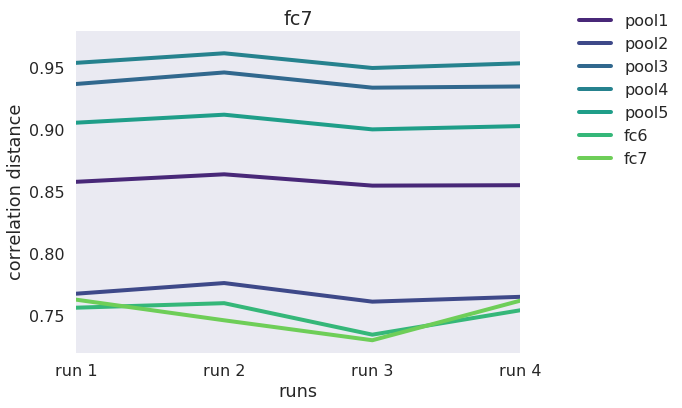

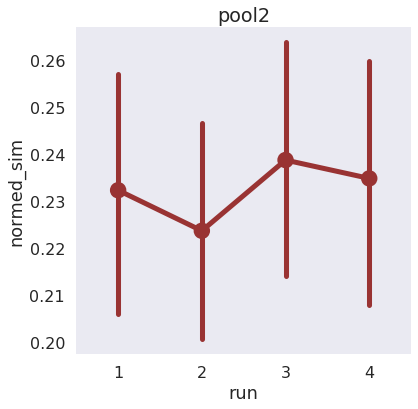

In [563]:
### which feature embedding are you using?
layers = ['P1','P2','P3','P4','P5','FC6','FC7']
layer_names = ['pool1','pool2','pool3','pool4','pool5','fc6','fc7']
colors = sns.color_palette("viridis", 8)
sns.set_context('poster')
sns.set_style('dark')
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
layer_counter = []
sub_counter = []
run_counter = []
SUPERSIM = []
FLATSIM = []
FLATDIST = []
for f, which_feat in enumerate(layer_names):
    FEATMAT = np.load('FEATURES_{}.npy'.format(layers[layer_names.index(which_feat)]))
    _X = pd.read_csv('METADATA.csv') # metadata is the same for all layers
    _Labels = np.load('LABELS.npy')

    import scipy.stats as stats
    run_starts = [320,330,340,350]
    run_stops = [329,339,349,359]

    SIM = []
    subs = np.unique(_X.subj)
    for i, sub in enumerate(subs):
        sim = []
        for start,end in zip(run_starts,run_stops):
            span = np.arange(start,end)
            axis = np.unique(_X[_X.subj==sub].axis.values)[0]
            o1 = axis.split('_')[0]
            o2 = axis.split('_')[1]
            o1_inds = (_X.label==o1) & (_X.subj==sub) & (pd.to_numeric(_X['trial'])>=start) & (pd.to_numeric(_X['trial'])<=end)
            o2_inds = (_X.label==o2) & (_X.subj==sub) & (pd.to_numeric(_X['trial'])>=start) & (pd.to_numeric(_X['trial'])<=end)
            assert sum(o1_inds)==5
            assert sum(o2_inds)==5
            FEAT_o1 = FEATMAT[o1_inds]
            FEAT_o2 = FEATMAT[o2_inds]
            MEANFEAT_o1 = FEATMAT[o1_inds].mean(0)
            MEANFEAT_o2 = FEATMAT[o2_inds].mean(0)
            sim.append(stats.pearsonr(MEANFEAT_o1,MEANFEAT_o2)[0])
            FLATSIM.append(stats.pearsonr(MEANFEAT_o1,MEANFEAT_o2)[0])
            FLATDIST.append(1-stats.pearsonr(MEANFEAT_o1,MEANFEAT_o2)[0])
            
            layer_counter.append(layer_names.index(which_feat))
            sub_counter.append(sub)
            run_counter.append(run_starts.index(start)+1)
        SIM.append(sim)
    SIM = np.array(SIM)
    
    if len(SUPERSIM)==0:
        SUPERSIM = SIM
    else:
        SUPERSIM = np.dstack((SUPERSIM,SIM))

    ## spearman correlation over the mean for each timewindow in each run
    sub_spearman2 = []
    for i, s in enumerate(SIM):
        assert s.shape==(SIM.shape[1],)
        sub_spearman2.append(1 - stats.spearmanr(np.arange(SIM.shape[1]),s)[0])    

    ## plot time series across runs of training
    plt.xlabel('runs')
    plt.ylabel('correlation distance')
    xinds = np.arange(4)
    yvals = 1 - SIM.mean(0)
    plt.xlim(0,3)
    plt.plot(xinds,yvals,color=colors[f],linewidth=4,label=which_feat)    
    run_labels = ['run 1','run 2','run 3', 'run 4']    
    tick = plt.xticks(xinds,run_labels) 
    plt.title(which_feat)
    plt.ylim(0.72,0.98)   
    plt.legend() 
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()    
    plt.savefig(os.path.join('./plots','similarity_sketch_timecourse_acrossruns_{}.pdf'.format(which_feat)))  
    
    W = pd.DataFrame([subs,sub_spearman2])
    W = W.transpose()
    W.columns = ['subj','runwise_similarity_change']
    W.to_csv('sketch_similarity_timecourse_across_runs_{}.csv'.format(which_feat))
    
    
Z = pd.DataFrame([FLATSIM, layer_counter, sub_counter, run_counter,FLATDIST])
Z = Z.transpose()
Z.columns = ['similarity','layer','subj','run','distance']

## grand-mean normalize subjects (subtract subject mean, add back grand mean)
sub_means = dict(zip(np.unique(Z.subj.values),Z.groupby('subj')['similarity'].apply(lambda x: np.mean(x)).values))
grand_mean = np.mean(Z.groupby('subj')['similarity'].apply(lambda x: np.mean(x)).values)
normed_sim = []
for i,d in Z.iterrows():
    normed_sim.append(d['similarity'] - sub_means[d.subj] + grand_mean)
Z = Z.assign(normed_sim=pd.Series(normed_sim).values)

which_feat = 1
_Z = Z[Z['layer']==which_feat]
plt.figure(figsize=(6,6))
sns.pointplot(x="run", 
              y="normed_sim", 
              data=_Z, 
              color=(0.6,0.2,0.2))
# plt.ylim([0.6,0.9])
plt.title(layer_names[which_feat])
plt.savefig('./plots/across_run_{}_distance_timecourse.pdf'.format(layer_names[which_feat]))
# plt.close()    

#### within-run dynamics 

In [520]:
### which feature embedding are you using?
which_feat = 'pool1'

_X = pd.read_csv('METADATA.csv') # metadata is the same for all layers
_Labels = np.load('LABELS.npy')    

colors = sns.color_palette("viridis", 8)
sns.set_context('poster')
sns.set_style('dark')
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

num_runs = 4
run_length = 10
first_trial = int(min(X.trial))
last_trial = int(max(X.trial)) 
window_size = 4 # width of moving window in # of trials

for f, which_feat in enumerate(layer_names):
    print(which_feat)
    FEATMAT = np.load('FEATURES_{}.npy'.format(layers[layer_names.index(which_feat)]))    
    _X = pd.read_csv('METADATA.csv') # metadata is the same for all layers
    _Labels = np.load('LABELS.npy')
    
    subs = np.unique(_X.subj)
    SIM = []
    for sub in subs:
        Sim = []
        for n in np.arange(num_runs):
            sim = []
            start = first_trial + run_length*n
            end = first_trial + run_length*(n+1) - 1
            num_windows = end-start-window_size+2 ## 
            for _n in np.arange(num_windows):
                _start = start + _n
                _end = start + _n + window_size                
                axis = np.unique(_X[_X.subj==sub].axis.values)[0]
                o1 = axis.split('_')[0]
                o2 = axis.split('_')[1]
                o1_inds = (_X.label==o1) & (_X.subj==sub) & (pd.to_numeric(_X['trial'])>=_start) & (pd.to_numeric(_X['trial'])<_end)
                o2_inds = (_X.label==o2) & (_X.subj==sub) & (pd.to_numeric(_X['trial'])>=_start) & (pd.to_numeric(_X['trial'])<_end)
                assert sum(o1_inds)==window_size/2
                assert sum(o2_inds)==window_size/2        
                FEAT_o1 = FEATMAT[o1_inds]
                FEAT_o2 = FEATMAT[o2_inds]
                MEANFEAT_o1 = FEAT_o1.mean(0)
                MEANFEAT_o2 = FEAT_o2.mean(0)
                sim.append(stats.pearsonr(MEANFEAT_o1,MEANFEAT_o2)[0])
            Sim.append(sim)
        SIM.append(Sim)
    SIM = np.array(SIM)

    plt.plot(SIM.mean(0).mean(0),color=colors[f],linewidth=4,label=which_feat)
    plt.xlabel('time window (size = {})'.format(window_size))
    plt.ylabel('feature similarity')
    plt.title('within-run change in similarity between sketches {}'.format(which_feat))
    plt.legend() 
    ax.legend(bbox_to_anchor=(1.1, 1.1))
    plt.tight_layout()  
    plt.savefig('./plots/within_run_similarity_timecourse_{}.pdf'.format(which_feat))
    plt.close()

    ## compute spearman correlation between time window and feature similarity within-run as index of learning
    ## spearman correlation over each run separately, then mean
    sub_spearman = []
    runwise = []
    for sub in SIM:
        run_spearman = []
        for run in sub:
            assert run.shape==(SIM.shape[2],)
            run_spearman.append(stats.spearmanr(np.arange(SIM.shape[2]),run)[0])
        runwise.append(run_spearman)
        sub_spearman.append(1 - np.mean(run_spearman))

    ## spearman correlation over the mean for each timewindow in each run
    sub_spearman2 = []
    for i, s in enumerate(SIM.mean(1)):
        assert s.shape==(SIM.shape[2],)
        sub_spearman2.append(1 - stats.spearmanr(np.arange(SIM.shape[2]),s)[0])    

    W = pd.DataFrame([subs,sub_spearman2])
    W = W.transpose()
    W.columns = ['subj','runwise_similarity_change']
    W.to_csv('sketch_similarity_timecourse_within_run_{}.csv'.format(which_feat))

In [230]:
## grand-mean normalize subjects (subtract subject mean, add back grand mean)
sub_means = SIM.mean(1).mean(1)
grand_mean = SIM.mean(0).mean(0).mean(0)
normed_SIM = []
for i,s in enumerate(SIM):
    normed_SIM.append(s - sub_means[i] + grand_mean)
normed_SIM = np.array(normed_SIM)    

##################  SIMILARITY   ####################################

### plot the timecourse with within-subject error bars
hfont = {'fontname':'Helvetica Neue'}
sns.set_context('poster')
sns.set_style('dark')
fig = plt.figure(figsize=(4,4))
sem = normed_SIM.mean(0).std(0)/np.sqrt(normed_SIM.shape[0])*1
plt.errorbar(np.arange(1,normed_SIM.shape[2]+1),
             normed_SIM.mean(0).mean(0),
             yerr=sem,color=(0.05,0.05,0.05),
             linewidth=5)
# lim = plt.ylim([0.145,0.185])
xlims = [0.95,normed_SIM.shape[2]+0.05]
lim = plt.xlim([xlims[0],xlims[1]])
# plt.axvspan(xlims[0],xlims[1], alpha=0.4, color='red')    
plt.xlabel('sketch number (window size = 4)', **hfont)
plt.ylabel('feature similarity', **hfont)
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/within_run_similarity_timecourse_{}.pdf'.format(which_feat))

##################        DISTANCE   ####################################
### plot the DISTANCE timecourse with within-subject error bars
hfont = {'fontname':'Helvetica Neue'}
sns.set_context('poster')
sns.set_style('dark')
fig = plt.figure(figsize=(4,4))
sem = normed_SIM.mean(0).std(0)/np.sqrt(normed_SIM.shape[0])*1
plt.errorbar(np.arange(1,normed_SIM.shape[2]+1),
             1-normed_SIM.mean(0).mean(0),
             yerr=sem,color=(0.05,0.05,0.05),
             linewidth=5)
# lim = plt.ylim([0.815,0.855])
xlims = [0.95,normed_SIM.shape[2]+0.05]
lim = plt.xlim([xlims[0],xlims[1]])
# plt.axvspan(xlims[0],xlims[1], alpha=0.4, color='red')    
plt.xlabel('repetition (sliding window size = 4)', **hfont)
plt.ylabel('correlation distance', **hfont)
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/within_run_differentiation_timecourse_{}.pdf'.format(which_feat))

In [224]:
## bootstrap spearman correlation
which_feat = 'fc6'
W = pd.read_csv('sketch_similarity_timecourse_within_run_{}.csv'.format(which_feat))
sub_spearman2 = W.runwise_similarity_change.values
w = sub_spearman2
nIter = 10000
boot_sp = []
for i in np.arange(nIter):
    boot_sp.append(np.mean(np.random.choice(w,len(w),replace=True)))
boot_sp = np.array(boot_sp)     
from __future__ import division
print 'p = ' + str(sum(boot_sp>1)/len(boot_sp)*2)

p = 0.0564


#### get full 40x40 correlation matrix across sketches

spearman
p = 0.049
pearson
p = 0.0484


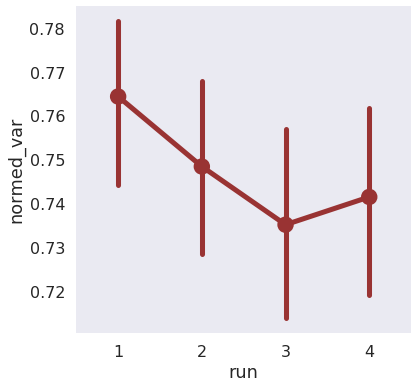

In [559]:
which_feat = 'fc7'
FEATMAT = np.load('FEATURES_{}.npy'.format(layers[layer_names.index(which_feat)]))    
_X = pd.read_csv('METADATA.csv') # metadata is the same for all layers
_Labels = np.load('LABELS.npy')    

def extract_block_diagonals(MAT,num_blocks):
    Blocks = []
    run_starts = map(int,np.linspace(0,MAT.shape[0],num_blocks+1))[:num_blocks]
    run_stops = map(int,np.linspace(0,MAT.shape[0],num_blocks+1))[1:]
    for start,stop in zip(run_starts,run_stops):
        Blocks.append(MAT[start:stop,start:stop])
    return np.array(Blocks)

import scipy

O1_early_var = []
O1_late_var = []
O2_early_var = []
O2_late_var = []

O1_run1_var = []
O1_run2_var = []
O1_run3_var = []
O1_run4_var = []

O2_run1_var = []
O2_run2_var = []
O2_run3_var = []
O2_run4_var = []

VAR = []
OBJ = []
RUN = []
SUB = []

for sub in subs:
    S = _X.sort_values(['subj','label','trial'])
    t_inds = np.array(S.index)
    _FEATMAT = FEATMAT[t_inds]
    s_inds = (S.subj==sub)
    s = S[s_inds]
    assert s.shape==(40,11)
    feat = _FEATMAT[s_inds]
    MAT = 1 - np.corrcoef(feat)
    o1_early = MAT[:10,:10]
    o1_late = MAT[10:20,10:20]
    o2_early = MAT[20:30,20:30]
    o2_late = MAT[30:40,30:40]
    Blocks = extract_block_diagonals(MAT,8)
    
    O1_run1 = Blocks[0]
    O1_run2 = Blocks[1]
    O1_run3 = Blocks[2]
    O1_run4 = Blocks[3]

    O2_run1 = Blocks[4]
    O2_run2 = Blocks[5]
    O2_run3 = Blocks[6]
    O2_run4 = Blocks[7]   
    
    upper_inds = np.triu_indices(10,k=1) 
    upper_inds_run = np.triu_indices(5,k=1) 
    
    O1_early_var.append(np.mean(o1_early[upper_inds]))
    O1_late_var.append(np.mean(o1_late[upper_inds]))
    O2_early_var.append(np.mean(o2_early[upper_inds]))
    O2_late_var.append(np.mean(o2_late[upper_inds]))
    
    VAR.append([np.mean(O1_run1[upper_inds_run]),
                np.mean(O1_run2[upper_inds_run]),
                np.mean(O1_run3[upper_inds_run]),
                np.mean(O1_run4[upper_inds_run]),
                np.mean(O2_run1[upper_inds_run]),
                np.mean(O2_run2[upper_inds_run]),
                np.mean(O2_run3[upper_inds_run]),
                np.mean(O2_run4[upper_inds_run])])

    OBJ.append(['o1']*4 + ['o2']*4)
    RUN.append([1,2,3,4]*2)
    SUB.append([sub]*8)
    
    O1_run1_var.append(np.mean(O1_run1[upper_inds_run]))
    O1_run2_var.append(np.mean(O1_run2[upper_inds_run]))
    O1_run3_var.append(np.mean(O1_run3[upper_inds_run]))
    O1_run4_var.append(np.mean(O1_run4[upper_inds_run]))
  
    O2_run1_var.append(np.mean(O2_run1[upper_inds_run]))
    O2_run2_var.append(np.mean(O2_run2[upper_inds_run]))
    O2_run3_var.append(np.mean(O2_run3[upper_inds_run]))
    O2_run4_var.append(np.mean(O2_run4[upper_inds_run])) 
    
def flatten(x):
    return [item for sublist in x for item in sublist]

VAR, OBJ, RUN, SUB = map(flatten, [VAR, OBJ, RUN, SUB])

## make dataframe
V = pd.DataFrame([VAR, OBJ, RUN, SUB])
V = V.transpose()
V.columns = ['var','obj','run','subj']

## grand-mean normalize subjects (subtract subject mean, add back grand mean)
sub_means = dict(zip(np.unique(V.subj.values),V.groupby('subj')['var'].apply(lambda x: np.mean(x)).values))
grand_mean = np.mean(V.groupby('subj')['var'].apply(lambda x: np.mean(x)).values)
normed_var = []
for i,d in V.iterrows():
    normed_var.append(d['var'] - sub_means[d.subj] + grand_mean)
V = V.assign(normed_var=pd.Series(normed_var).values)

## plotting
plt.figure(figsize=(6,6))
sns.pointplot(x="run", 
              y="normed_var", 
              data=V, 
              color=(0.6,0.2,0.2))
# plt.ylim([0.7,0.8])
plt.tight_layout
plt.savefig('./plots/across_run_{}_similarity_timecourse.pdf'.format(which_feat))
# plt.close() 

subs = np.unique(V.subj.values)
sub_spearman = []
sub_pearson = []
for sub in subs:
    _V = V[V['subj']==sub]
    o1_trend = stats.spearmanr(np.arange(4),_V[_V['obj']=='o1']['normed_var'].values)[0]
    o2_trend = stats.spearmanr(np.arange(4),_V[_V['obj']=='o2']['normed_var'].values)[0]  
    sub_spearman.append(np.mean([o1_trend,o2_trend]))
    o1_trend = stats.pearsonr(np.arange(4),_V[_V['obj']=='o1']['normed_var'].values)[0]
    o2_trend = stats.pearsonr(np.arange(4),_V[_V['obj']=='o2']['normed_var'].values)[0]      
    sub_pearson.append(np.mean([o1_trend, o2_trend]))
    
which_feat = 1
W = pd.DataFrame([subs,sub_spearman,sub_pearson])
W = W.transpose()
W.columns = ['subj','spearman_variance','pearson_variance']
W.to_csv('sketch_variance_timecourse_across_runs_{}.csv'.format(which_feat))

def bootstrap_gt0(w,nIter=10000):
    boot_sp = []
    for i in np.arange(nIter):
        boot_sp.append(np.mean(np.random.choice(w,len(w),replace=True)))
    boot_sp = np.array(boot_sp)     
    print 'p = ' + str(sum(boot_sp>0)/len(boot_sp)*2)
    return boot_sp

print 'spearman'
boot = bootstrap_gt0(sub_spearman)
print 'pearson'
boot = bootstrap_gt0(sub_pearson)    

##### dataframe with all early vs. late and runwise feature variance estimates

In [513]:
V = pd.DataFrame([O1_early_var,O1_late_var,O2_early_var,O2_late_var,list(subs),
                 O1_run1_var,O1_run2_var,O1_run3_var,O1_run4_var,
                 O2_run1_var,O2_run2_var,O2_run3_var,O2_run4_var])
V = V.transpose()
V.columns = ['o1_early_var','o1_late_var','o2_early_var','o2_late_var','subj',
            'O1_run1_var','O1_run2_var','O1_run3_var','O1_run4_var',
            'O2_run1_var','O2_run2_var','O2_run3_var','O2_run4_var']

o1_diff = V.o1_late_var.values - V.o1_early_var.values
o2_diff = V.o2_late_var.values - V.o2_early_var.values
o_diff = list(np.vstack((o1_diff,o2_diff)).mean(0))

In [514]:
V = V.assign(o1_diff=pd.Series(o1_diff).values)
V = V.assign(o2_diff=pd.Series(o2_diff).values)
V = V.assign(o_diff=pd.Series(o_diff).values)
print np.mean(V.o_diff)

-0.0349428896506


p = 8e-05


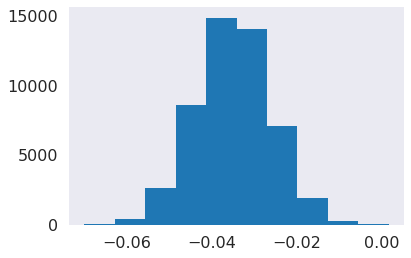

In [519]:
bootmean = bootstrap_gt0(V.o_diff.values)
h = plt.hist(bootmean)

### Set up test for early vs. late in training

In [520]:
first_trial = int(min(X.trial))
last_trial = int(max(X.trial))
num_trials = last_trial-first_trial+1

In [521]:
## split up by first vs. second half of training phase
first_half = np.arange(first_trial,last_trial-num_trials/2+1)
second_half = np.arange(last_trial-num_trials/2+1,last_trial+1)

inds1 = _X['trial']<str(max(first_half))
inds2 = _X['trial']>=str(max(first_half))

X1 = _X[inds1]
X2 = _X[inds2]
assert len(X1)==len(X2)

FEAT1 = _Features[inds1]
FEAT2 = _Features[inds2]

LABELS1 = _Labels[inds1]
LABELS2 = _Labels[inds2]

clf = linear_model.LogisticRegression(penalty='l2')
print("Now fitting first half...")
scores = cross_val_score(clf, FEAT1, LABELS1, cv=12)
print("Accuracy on first half: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Now fitting second half...")
scores = cross_val_score(clf, FEAT2, LABELS2, cv=12)
print("Accuracy on second half: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Now fitting first half...
Accuracy on first half: 0.86 (+/- 0.09)
Now fitting second half...
Accuracy on second half: 0.88 (+/- 0.07)


In [524]:
_X = assign_axis_to_metadata(_X)
inds_bed_bench = _X.axis=='bed_bench'
inds_bed_chair = _X.axis=='bed_chair'
inds_bed_table = _X.axis=='bed_table'
inds_bench_chair = _X.axis=='bench_chair'
inds_bench_table = _X.axis=='bench_table'
inds_chair_table = _X.axis=='chair_table'

In [527]:
def subset_feats(X,Features,axis,epoch):
    '''
    X = metadata dataframe
    Features = feature matrix
    axis = which object pair is trained, e.g. 'bed_bench'
    epoch = 'early' if first half, 'late' if second half, or 'all'
    
    '''
    if epoch=='early':
        inds = (X.axis==axis) & (pd.to_numeric(X['trial'])<max(first_half))
    elif epoch=='late':
        inds = (X.axis==axis) & (pd.to_numeric(X['trial'])>=max(first_half))
    elif epoch=='initial':
        inds = (X.axis==axis) & (pd.to_numeric(X['trial'])<=329) 
    elif epoch=='final':
        inds = (X.axis==axis) & (pd.to_numeric(X['trial'])>349) 
    elif epoch=='all':
        inds = (X.axis==axis)
    _X = X[inds]
    labels = list(_X.label.values)
    _Features = Features[inds]
    return _X, labels, _Features
    
def subset_feats_by_subject(_X,Features,epoch,subj):
    '''
    X = metadata dataframe
    Features = feature matrix
    epoch = 'early' if first half, 'late' if second half, or 'all'
    subj = subject ID
    
    '''
    axis = np.unique(_X[_X.subj==sub].axis.values)[0]    
    if epoch=='early':
        inds = (_X.axis==axis) & (pd.to_numeric(_X['trial'])<=max(first_half)) & (_X.subj==subj) 
    elif epoch=='late':
        inds = (_X.axis==axis) & (pd.to_numeric(_X['trial'])>max(first_half)) & (_X.subj==subj)
    elif epoch=='initial':
        inds = (_X.axis==axis) & (pd.to_numeric(_X['trial'])<=329) & (_X.subj==subj) 
    elif epoch=='final':
        inds = (_X.axis==axis) & (pd.to_numeric(_X['trial'])>349) & (_X.subj==subj) 
    elif epoch=='all':
        inds = (_X.axis==axis) & (_X.subj==subj)
    X = _X[inds]
    labels = list(X.label.values)
    _Features = Features[inds]
    return X, labels, _Features, axis
        
def get_axis_from_sub(P, sub):
    return np.unique(P[P.subj==sub].axis.values)[0]

def get_objs_from_axis(axis):
    return axis.split('_')[0], axis.split('_')[1]    

In [526]:
def compute_dprime(true_labels,test_data, clf, labels=['bed','bench','chair','table']):

    confusion_mat = sklearn.metrics.confusion_matrix(true_labels,clf.predict(test_data),labels)

    objs = labels
    o1 = which_axis.split('_')[0]
    o2 = which_axis.split('_')[1]

    i1 = objs.index(o1)
    i2 = objs.index(o2)

    acc1 = confusion_mat[i1][i1]/confusion_mat[i1].sum()
    acc2 = confusion_mat[i2][i2]/confusion_mat[i2].sum()
    fa1 = confusion_mat[i2][i1]/confusion_mat[i2].sum() ## false alarm to o1 when actually o2
    fa2 = confusion_mat[i1][i2]/confusion_mat[i1].sum() ## false alarm to o2 when actually o1
    
    acc = np.mean([acc1, acc2])
    fa = np.mean([fa1, fa2])

    Z = norm.ppf
    dprime = Z(acc) - Z(fa)
    return dprime
    

In [814]:
Early_Acc = []
Early_Dprime = []
Late_Acc = []
Late_Dprime = []

for a in list(unique_axes):

    which_axis = a
    # train only on baseline sketches (independent data)
    clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1).fit(BaselineFeatures, BaselineLabels)

    X1,L1,F1 = subset_feats(_X,_Features,which_axis,'initial')
    score = clf.score(F1, L1)
    Early_Acc.append(score)
    d = compute_dprime(L1,F1, clf)
    Early_Dprime.append(d)
    print("Accuracy {} early: {}".format(which_axis, score))
    print("D-prime {} early: {}".format(which_axis, d))
          
    X2,L2,F2 = subset_feats(_X,_Features,which_axis,'final')
    score = clf.score(F2, L2)
    d = compute_dprime(L2,F2, clf)
    print("Accuracy {} late: {}".format(which_axis, score))         
    print("D-prime {} late: {}".format(which_axis, d))                       
    Late_Acc.append(score)
    Late_Dprime.append(d)

    print ' '

Accuracy bed_bench early: 0.75
D-prime bed_bench early: 1.42990477656
Accuracy bed_bench late: 0.7
D-prime bed_bench late: 1.36602174628
 
Accuracy bed_chair early: 0.833333333333
D-prime bed_chair early: inf
Accuracy bed_chair late: 0.683333333333
D-prime bed_chair late: 1.97812637453
 
Accuracy bed_table early: 0.733333333333
D-prime bed_table early: 2.12401166925
Accuracy bed_table late: 0.8
D-prime bed_table late: 2.34270717962
 
Accuracy bench_chair early: 0.728571428571
D-prime bench_chair early: 2.07373192719
Accuracy bench_chair late: 0.757142857143
D-prime bench_chair late: 2.16237522753
 
Accuracy bench_table early: 0.733333333333
D-prime bench_table early: 1.81474189489
Accuracy bench_table late: 0.733333333333
D-prime bench_table late: 2.00591985031
 
Accuracy chair_table early: 0.716666666667
D-prime chair_table early: 2.21782117545
Accuracy chair_table late: 0.883333333333
D-prime chair_table late: 3.0257308075
 


#### Now break out by subject

In [786]:
subs = np.unique(_X.subj)

In [816]:
Early_Acc = []
Late_Acc = []
TrainedAxis = []

for sub in subs:

    # train only on baseline sketches (independent data)
    axis = get_axis_from_sub(_P,sub)
    objs = get_objs_from_axis(axis)
    _inds = [i for i,j in enumerate(BaselineLabels) if j in objs]
    _BaselineLabels = BaselineLabels[_inds]
    _BaselineFeatures = BaselineFeatures[_inds]                        
    clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1).fit(_BaselineFeatures, _BaselineLabels)

    print 'For subject {}'.format(sub)
    X1,L1,F1,A1 = subset_feats_by_subject(_X,_Features,'initial',sub)
    score = clf.score(F1, L1)
    Early_Acc.append(score)
    TrainedAxis.append(A1)
    print("Accuracy {} initial: {}".format(which_axis, score))

    X2,L2,F2,A2 = subset_feats_by_subject(_X,_Features,'final',sub)
    score = clf.score(F2, L2)
    # d = compute_dprime(L2,F2)
    print("Accuracy {} final: {}".format(which_axis, score))         
    Late_Acc.append(score)

    print ' '

For subject 0110171_neurosketch
Accuracy chair_table initiail: 0.9
Accuracy chair_table final: 0.7
 
For subject 0110172_neurosketch
Accuracy chair_table initiail: 0.8
Accuracy chair_table final: 0.6
 
For subject 0111171_neurosketch
Accuracy chair_table initiail: 0.9
Accuracy chair_table final: 0.8
 
For subject 0112171_neurosketch
Accuracy chair_table initiail: 0.9
Accuracy chair_table final: 0.8
 
For subject 0112172_neurosketch
Accuracy chair_table initiail: 0.8
Accuracy chair_table final: 0.8
 
For subject 0112173_neurosketch
Accuracy chair_table initiail: 0.7
Accuracy chair_table final: 0.9
 
For subject 0113171_neurosketch
Accuracy chair_table initiail: 1.0
Accuracy chair_table final: 0.8
 
For subject 0115172_neurosketch
Accuracy chair_table initiail: 0.6
Accuracy chair_table final: 0.5
 
For subject 0115174_neurosketch
Accuracy chair_table initiail: 0.8
Accuracy chair_table final: 0.7
 
For subject 0117171_neurosketch
Accuracy chair_table initiail: 0.8
Accuracy chair_table fin

In [820]:
W = pd.DataFrame([subs,Early_Acc,Late_Acc,TrainedAxis])
W = W.transpose()
W.columns = ['subj','early_score','late_score','axis']
W.to_csv('sketch_recognizability_timecourse_initial10_vs_final10.csv')

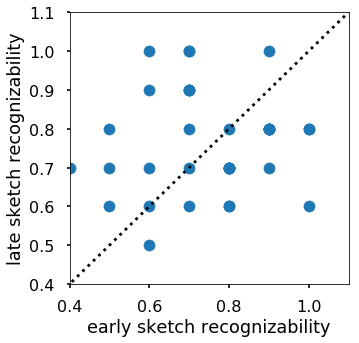

In [818]:
fig = plt.figure(figsize=(5,5))
plt.scatter(Early_Acc,Late_Acc)
plt.xlim([0.4,1.1])
plt.ylim([0.4,1.1])
plt.plot([0,1.1],[0,1.1],'k:')
plt.xlabel('early sketch recognizability')
plt.ylabel('late sketch recognizability')

In [494]:
df = pd.DataFrame([list(subs),Early_Acc,Late_Acc,TrainedAxis])
df = df.transpose()
df.columns = ['subj','early_draw_score','late_draw_score','trained_axis']
df.to_csv('sketches/drawing_recognizability_early_vs_late.csv')

### Extract partial sketch features and analyze time course of recognizability within sketch

In [229]:
from embedding import *
partial_sketch_dir = '../partial_sketches'
partial_paths = list_files(partial_sketch_dir)

def save_partial_features(Features, Labels, Chunks, Subjs, Trials, X, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']
    np.save('FEATURES_PARTIAL_{}.npy'.format(layers[layer_num]), Features)
    np.save('LABELS_PARTIAL.npy', Labels)      
    return layer_num

def preprocess_features(Features, Labels, X):
    # normalize feature vectors & plot full image-level similarity matrix
    _X = X.sort_values(['label','viewpoint','subj'])
    inds = np.array(_X.index)
    _Features = normalize(Features[inds])
    _Labels = Labels[inds]
    return _Features, _Labels, _X

In [ ]:
extractor = PartialFeatureExtractor(partial_paths,6)
Features, Labels, Chunks, Subjs, Trials = extractor.extract_feature_matrix()

In [227]:
for layer_ind in np.arange(6,7):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    print('Extracting Layer {}'.format(layers[layer_ind]))
    extractor = PartialFeatureExtractor(partial_paths,layer_ind)
    Features, Labels, Chunks, Subjs, Trials = extractor.extract_feature_matrix()  
    
    P = pd.DataFrame([Labels,Chunks,Subjs,Trials])
    P = P.transpose()
    P.columns = ['label','chunk','subj','trial']
    P.to_csv('METADATA_PARTIAL.csv')      
        
    print('Preprocessing features...')
    subset_size = 10000 ## if num feature dimensions exceeds this value, take random subset of features
    if Features.shape[1]>10000:
        subset_inds = np.random.RandomState(0).permutation(Features.shape[1])[:subset_size]
        Features = Features[:,subset_inds]        
    _Features, _Labels, _P = preprocess_features(Features, Labels, P)
    _P = assign_axis_to_metadata(_P)
    layer_num = save_partial_features(_Features, _Labels, _Chunks, _Subjs, _Trials,  _P, layer_ind)


<module 'embedding' from 'embedding.py'>

In [49]:
def get_chunk_from_path(path):
    return int(path.split('/')[-1].split('.')[0]) 
def get_trial_from_path(path):
    return int(path.split('/')[-2].split('_')[1]) 
def get_label_from_path(path):
    return path.split('/')[-2].split('_')[0] 
def get_subj_from_path(path):
    return path.split('/')[-3]

In [50]:
num_sketches = len(partial_paths)

In [563]:
def load_image(path, imsize=224, volatile=True, use_cuda=False):
    im = Image.open(path)
    im = im.convert('RGB')

    loader = transforms.Compose([
        transforms.Scale(imsize),
        transforms.ToTensor()])

    im = Variable(loader(im), volatile=volatile)
    im = im.unsqueeze(0)
    if use_cuda:
        im = im.cuda(cuda_device)
    return im

def sketch_generator(paths, imsize=224, use_cuda=use_cuda):
    for path in paths:
        sketch = load_image(path)
        label = get_label_from_path(path)
        chunk = get_chunk_from_path(path)
        subj = get_subj_from_path(path)
        trial = get_trial_from_path(path)
        yield (sketch, label, chunk, subj, trial)
        
# define generator
generator = sketch_generator(partial_paths,imsize=224,use_cuda=use_cuda)

# initialize sketch and label matrices
Features = []
Labels = []
Chunks = []
Subjs = []
Trials = []
n = 0
quit = False 

# generate batches of sketches and labels    
if generator:
    while True:    
        batch_size = 64
        sketch_batch = Variable(torch.zeros(batch_size, 3, 224, 224))
        if use_cuda:
            sketch_batch = sketch_batch.cuda(cuda_device)                
        label_batch = []   
        chunk_batch = []
        subj_batch = []
        trial_batch = []
        print('Batch {}'.format(n + 1))            
        for b in range(batch_size):
            try:
                sketch, label, chunk, subj, trial = generator.next()
                sketch_batch[b] = sketch   
                label_batch.append(label)
                chunk_batch.append(chunk)
                subj_batch.append(subj)
                trial_batch.append(trial)                
            except StopIteration:
                quit = True
                print 'stopped!'
                break                
            
        if n == num_sketches//batch_size:
            sketch_batch = sketch_batch.narrow(0,0,b)
            label_batch = label_batch[:b + 1] 
            chunk_batch = chunk_batch[:b + 1] 
            subj_batch = subj_batch[:b + 1] 
            trial_batch = trial_batch[:b + 1] 
        n = n + 1       

        # extract features from batch
        sketch_batch = vgg19_features(sketch_batch) 
        sketch_batch = sketch_batch.view(sketch_batch.size(0), -1)
        sketch_batch = vgg19_classifier(sketch_batch)
        sketch_batch = sketch_batch.cpu().data.numpy()

        if len(Features)==0:
            Features = sketch_batch
        else:
            Features = np.vstack((Features,sketch_batch))
        Labels.append(label_batch)
        Chunks.append(chunk_batch)        
        Subjs.append(subj_batch)
        Trials.append(trial_batch)

        if n == num_sketches//batch_size + 1:
            break
Labels = np.array([item for sublist in Labels for item in sublist])
Chunks = np.array([item for sublist in Chunks for item in sublist])
Subjs = np.array([item for sublist in Subjs for item in sublist])
Trials = np.array([item for sublist in Trials for item in sublist])

Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110
Batch 11

In [567]:
assert len(np.unique(Chunks))==23

In [435]:
load_in = 1 ## do you want to load in pre-computed features?

if load_in==0:
    P = pd.DataFrame([Labels,Chunks,Subjs,Trials])
    P = P.transpose()
    P.columns = ['label','chunk','subj','trial']
    P.to_csv('METADATA_PARTIAL.csv')

    # normalize partial sketch Features
    _Features = normalize(Features)
    np.save('FEATURES_PARTIAL.npy',Features)
    
else:    
    P = pd.read_csv('METADATA_PARTIAL.csv')
    Features = np.load('FEATURES_PARTIAL.npy')
    _Features = normalize(Features)    

In [436]:
def subset_feats_by_subject_and_chunk(P,Features,epoch,subj,chunk):
    '''
    P = metadata dataframe
    Features = feature matrix
    epoch = 'early' if first half of run, 'late' if second half of run, or 'all'
    subj = subject ID
    chunk = cumulative portion of sketch, ranges from 0-22
    '''
    axis = np.unique(P[P.subj==sub].axis.values)[0]
    num_trials_per_run = 10
    ntpr = num_trials_per_run
    if epoch=='early':
        inds = (P.axis==axis) & (P['trial'] % ntpr < 5) & (P.subj==subj) & (P.chunk==chunk) 
        assert sum(inds)==20        
    elif epoch=='late':
        inds = (P.axis==axis) & (P['trial'] % ntpr >= 5) & (P.subj==subj) & (P.chunk==chunk) 
        assert sum(inds)==20
    elif epoch=='all':
        inds = (P.axis==axis) & (P.subj==subj) & (P.chunk==chunk) 
    _P = P[inds]
    labels = list(_P.label.values)
    _Features = Features[inds]
    return _P, labels, _Features, axis

def get_axis_from_sub(P, sub):
    return np.unique(P[P.subj==sub].axis.values)[0]

def get_objs_from_axis(axis):
    return axis.split('_')[0], axis.split('_')[1]

In [439]:
## look up competitor for each trial
competitor = []
for index, row in P.iterrows():
    this_label = row['label']
    this_subj = row['subj']
    this_trial = row['trial']
    competitor.append(Y[(Y['trial']==this_trial) & (Y['target']==this_label) & (Y['wID']==this_subj)]['competitor'].values[0])
## assign competitor to P
P = P.assign(competitor=pd.Series(competitor).values)

## assign axis to P
_P = assign_axis_to_metadata(P)

In [440]:
Early_Acc = []
Late_Acc = []
All_Acc = []
TrainedAxis = []
chunk_ind = []

subs = np.unique(P.subj.values)

for _chunk in np.arange(23): 
    print 'Scoring chunk {}'.format(str(_chunk))    
    for sub in subs:

            # train only on baseline sketches (independent data)
            axis = get_axis_from_sub(_P,sub)
            objs = get_objs_from_axis(axis)
            _inds = [i for i,j in enumerate(BaselineLabels) if j in objs]
            _BaselineLabels = BaselineLabels[_inds]
            _BaselineFeatures = BaselineFeatures[_inds]                        
            clf = linear_model.LogisticRegression(penalty='l2',C=1,random_state=1).fit(_BaselineFeatures, _BaselineLabels)

            X1,L1,F1,A1 = subset_feats_by_subject_and_chunk(_P,_Features,'early',sub,_chunk)
            score = clf.score(F1, L1)
            Early_Acc.append(score)
            TrainedAxis.append(A1)

            X2,L2,F2,A2 = subset_feats_by_subject_and_chunk(_P,_Features,'late',sub,_chunk)
            score = clf.score(F2, L2)                      
            Late_Acc.append(score)
            chunk_ind.append(_chunk)
            
            XA,LA,FA,AA = subset_feats_by_subject_and_chunk(_P,_Features,'all',sub,_chunk)
            score = clf.score(FA, LA) 
            All_Acc.append(score)

Scoring chunk 0
Scoring chunk 1
Scoring chunk 2
Scoring chunk 3
Scoring chunk 4
Scoring chunk 5
Scoring chunk 6
Scoring chunk 7
Scoring chunk 8
Scoring chunk 9
Scoring chunk 10
Scoring chunk 11
Scoring chunk 12
Scoring chunk 13
Scoring chunk 14
Scoring chunk 15
Scoring chunk 16
Scoring chunk 17
Scoring chunk 18
Scoring chunk 19
Scoring chunk 20
Scoring chunk 21
Scoring chunk 22


In [496]:
assert len(Early_Acc)==23*len(subs)
sub_vec = np.tile(subs,23)

In [497]:
Q = pd.DataFrame([sub_vec,chunk_ind,Early_Acc,Late_Acc,All_Acc,TrainedAxis])
Q = Q.transpose()
Q.columns = ['subj','chunk','early','late','all','axis']
Q.to_csv('sketch_recognizability_timecourse_within_sketch_within_run_all_5vs5.csv')

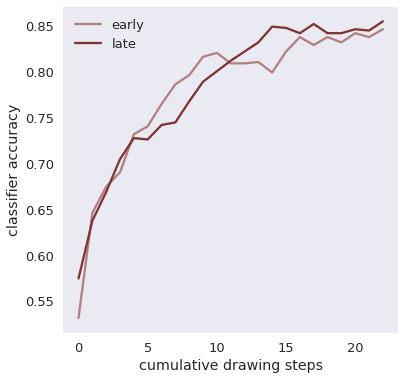

In [433]:
Q = pd.read_csv('sketch_recognizability_timecourse_within_sketch_within_run_all_5vs5.csv')
EQ = Q.groupby(['chunk'])['early']
LQ = Q.groupby(['chunk'])['late']
sns.set_context('talk')
sns.set_style('dark')
fig = plt.figure(figsize=(6,6))
plt.plot(EQ.apply(lambda x: np.mean(x)),color=(0.7,0.5,0.5),label='early')
plt.plot(LQ.apply(lambda x: np.mean(x)),color=(0.5,0.2,0.2),label='late')
plt.xlabel('cumulative drawing steps')
plt.ylabel('classifier accuracy')
plt.legend()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

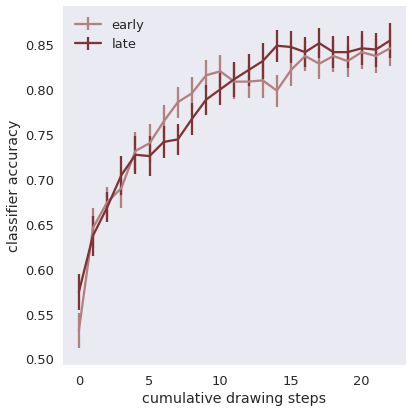

In [611]:
sns.set_style('dark')
Q = pd.read_csv('sketch_recognizability_timecourse_within_sketch_within_run_5vs5.csv')
num_subs = len(np.unique(Q.subj.values))
step_range = np.unique(Q.chunk.values)
EQ = Q.groupby(['chunk'])['early']
LQ = Q.groupby(['chunk'])['late']
sns.set_context('talk')
fig = plt.figure(figsize=(6,6))
plt.errorbar(step_range,
             EQ.apply(lambda x: np.mean(x)),
             color=(0.7,0.5,0.5),
             yerr=EQ.apply(lambda x: np.std(x)/np.sqrt(num_subs)),
             label='early')
plt.errorbar(step_range,
             LQ.apply(lambda x: np.mean(x)),
             color=(0.5,0.2,0.2),
             yerr=EQ.apply(lambda x: np.std(x)/np.sqrt(num_subs)),             
             label='late')
plt.xlabel('cumulative drawing steps')
plt.ylabel('classifier accuracy')
plt.legend()
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/within_sketch_recognizability_dynamics_byhalfrun.pdf')

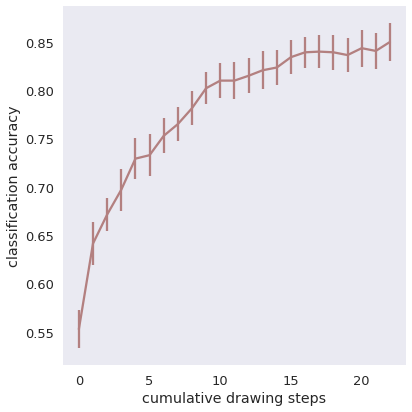

In [597]:
sns.set_style('dark')
Q = pd.read_csv('sketch_recognizability_timecourse_within_sketch_within_run_all_5vs5.csv')
num_subs = len(np.unique(Q.subj.values))
step_range = np.unique(Q.chunk.values)
AQ = Q.groupby(['chunk'])['all']
sns.set_context('talk')
fig = plt.figure(figsize=(6,6))
plt.errorbar(step_range,
             AQ.apply(lambda x: np.mean(x)),
             color=(0.7,0.5,0.5),
             yerr=EQ.apply(lambda x: np.std(x)/np.sqrt(num_subs)))
plt.xlabel('cumulative drawing steps')
plt.ylabel('classification accuracy')
# plt.legend()
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/within_sketch_recognizability_dynamics_collapsed.pdf')

In [519]:
sns.set_style('dark')
Q = pd.read_csv('sketch_recognizability_timecourse_within_sketch_within_run_all_5vs5.csv')
num_subs = len(np.unique(Q.subj.values))
step_range = np.unique(Q.chunk.values)
AQ = Q.groupby(['chunk'])['all']
sns.set_context('talk')

for counter in step_range:
    fig = plt.figure(figsize=(6,6))
    plt.errorbar(step_range[:counter],
                 AQ.apply(lambda x: np.mean(x))[:counter],
                 color=(0.9,0.5,0.5),
                 yerr=AQ.apply(lambda x: np.std(x)/np.sqrt(num_subs))[:counter]
                )
    plt.xlabel('cumulative drawing steps')
    plt.ylabel('classification accuracy')
    plt.xlim([0,max(step_range)])
    plt.ylim([0.5,0.9])    
    if not os.path.exists('./plots/within_sketch_partial/png'):
        os.makedirs('./plots/within_sketch_partial/png')
    plt.savefig('./plots/within_sketch_partial/png/within_sketch_recognizability_dynamics_collapsed_{}.png'.format(str(counter)))
    plt.close(fig)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])